# Simulation (ctobssim) 
## (no output on disk. Everything is saved in memory)

The purpose of this notebook is to perform a simulation using `ctobbsim` (and other scripts), create a count map with `ctskymap`, fit the spectrum with `cssens` and plot the spectrum using a function in the script `make_spectrum` (which comes together with ctools). 

In order to do this, one has two options:
- create an *observation container* file with the [given notebook](observation_definition.ipynb), in which many different pointings can be specified and might be useful for some specific analysis;
- perform a simpler simulation, setting everything directly in this notebook.

In [1]:
import gammalib
import ctools
import cscripts

# this is for later
obsutils_bool = False

# 1) Model Creation (TO BE DONE) -
# use the crab model 

We only need to provide a **model** for the source that we want to simulate. We have to give a model for the source to be simulated: since many sources are simulated together, the xml model will have a piece for every source to simulate, including the background. An example model is $CTOOLS/share/models/crab.xml.

In [ ]:
#!xmllint $CTOOLS/share/models/crab.xml


The model of the source can be created in many ways, either by hand, editing an existing model (for example the crab model) and adjusting the parameters to the desired value.

We have written a script which read in input all the data concerning the source that one wants to simulate (both the source itself and the background). More details can be found in sexten_2017/event_creator/Model_Creation.ipynb


# 2) Set up the simulation
## NOTE: choose just one of the following options.
The simulation can be set up in two main different ways: 
## - **WITH** *the observation definition XML* file (built with  [this](observation_definition.ipynb) notebook)...

In [2]:
# run the following cell which takes into account properly how the simulation is done
# will be used in the spectrum calculation

obs_cont_bool = True

### a) using the gammalib library

In [ ]:
obs = gammalib.GObservations('out_csobsdef.xml')
obs.models(gammalib.GModels("${CTOOLS}/share/models/crab.xml"))
sim = ctools.ctobssim(obs)
sim.run()

### b) OR using only ctools

In [3]:
sim = ctools.ctobssim()
sim["inobs"] = "out_csobsdef.xml"
sim["inmodel"] = "${CTOOLS}/share/models/crab.xml"   #we load a sample model
sim.run()

### ...and both in case a) and b) one can also retreive the results with sim.obs()[*id_num*].events()...

In [4]:
# ...and print the results
#print(sim.obs())
print(sim.obs()[0].events())   #for the first pointing (id = 0001)
#print(sim.obs()[1].events())   #for the second pointing (id = 0002)...and so on

=== GCTAEventList ===
 Number of events ..........: 859 (loaded)
 Time interval .............: 51544.5 - 51544.5003472222 days
=== GEbounds ===
 Number of intervals .......: 1
 Energy range ..............: 50 GeV - 20 TeV
=== GCTARoi ===
 ROI centre ................: RA=83.6331, DEC=22.0145 [0,0]
 ROI radius ................: 8 deg


## - WITHOUT the observation definition XML file, 

In [ ]:
# run the following cell which takes into account properly how the simulation is done
# will be used in the spectrum calculation

obs_cont_bool = False

## either by:

### c) using the cscripts named csobsutil,

In [ ]:
# the variable obsutils_bool is set uqual to True since we are performing the simulation with csobsutils
obsutils_bool = True
ra = 83.6331
dec = 22.0145
dur = 30        # seconds
emin = 0.05          # in TeV
emax = 20.0          # in TeV
rad = 8.0
caldb = 'prod2'
irf = 'South_0.5h'
deadc = 0.95

pattern = cscripts.obsutils.set_obs_patterns("single", ra=ra, dec=dec, offset=1.0)   #the other option is "four"
obs = cscripts.obsutils.set_obs_list(pattern, duration=dur, emin=emin, emax=emax, rad=rad, caldb=caldb, irf=irf, deadc = deadc)
obs.models(gammalib.GModels("${CTOOLS}/share/models/crab.xml"))
sim = cscripts.obsutils.sim(obs)


### (and again the results can be displayed)

### [**NOTE**: only in this case the results must be seen with sim[0].events() and not sim.obs()[0].events() as in the other cases.]

In [ ]:
print(sim[0].events())

### d) OR using directly ctobssim.

In [ ]:
ra, dec = 83.6331, 22.0145
dur = 30                         # seconds
emin, emax = 0.05, 20.0          # in TeV
rad, deadc = 8.0, 0.95
caldb, irf = 'prod2','South_0.5h'

In [ ]:
sim = ctools.ctobssim()
sim["inmodel"] = "${CTOOLS}/share/models/crab.xml"
sim["outevents"] = "events.fits"
sim["ra"] = ra
sim["dec"] = dec
sim["rad"] = rad
sim["tmin"] = 0.0
sim["tmax"] = dur
sim["emin"] = emin
sim["emax"] = emax
sim["caldb"] = caldb
sim["irf"] = irf
sim.run()

### And again see the results stored in memory.

In [ ]:
print(sim.obs())

# 3) View the results
## 3.1) Create a count map with the tool ctskymap.

In [5]:
# we clone the sim object because when the skymap instance is executed, it is deleted.
# so it's better to copy it before executing anything.

if obsutils_bool == True:
    sim_cp = sim.copy()
else:
    sim_cp = sim.obs().copy()

In [6]:
name_map_out = "skymap.fits"

skymap = ctools.ctskymap(sim_cp)
skymap['emin'] = 0.1
skymap['emax'] = 100
skymap['nxpix'] = 20
skymap['nypix'] = 20
skymap['binsz'] = 0.5
skymap['coordsys'] = "CEL"
skymap['proj'] = "AIT"
skymap['xref'] = 83.63 #RA
skymap['yref'] = 22.01 #DEC
skymap['bkgsubtract'] = "NONE" 
skymap['outmap'] = name_map_out
skymap.execute()

and we view it with ds9:

In [8]:
!ds9 -wcs icrs -wcs skyformat degrees skymap.fits

Another option is to view it using matplotlib and the astropy library

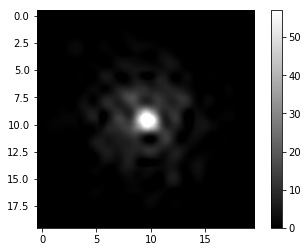

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits

hdu_list = fits.open(name_map_out)
image_data = hdu_list[0].data
plt.imshow(image_data, cmap='gray', interpolation = 'sinc')#, vmin=0)
plt.colorbar()
#plt.savefig("out.png")

# 4) Likelihood

# 5) Spectrum
This part is taken from the script make_spectrum.py which is by default installed in */usr/local/gamma/share/examples/python*.

In [9]:
# this is necessary due to the different output from the different tools 
if obsutils_bool == True:
    sim_spec = sim.copy()
else:
    sim_spec = sim.obs().copy()

if obs_cont_bool == True:
    src_name = sim_spec[0].name()
else:
    src_name = sim_spec.models()["Crab"].name()
 
print(src_name)

Crab


In [10]:
#spec = cscripts.csspec(sim.obs())
spec = cscripts.csspec(sim_spec)
spec['srcname']  = src_name
spec['outfile']  = 'example_spectrum.fits'
spec['expcube']  = 'NONE'
spec['psfcube']  = 'NONE'
spec['bkgcube']  = 'NONE'
spec['edisp']    = False
spec['emin']     = sim_spec[0].events().emin().TeV()
spec['emax']     = sim_spec[0].events().emax().TeV()
spec['enumbins'] = 10
spec['ebinalg']  = 'LOG'
spec.run()
#spec.save()


In [11]:
spectrum = spec.spectrum()

In [12]:
from make_spectrum import plot_spectrum

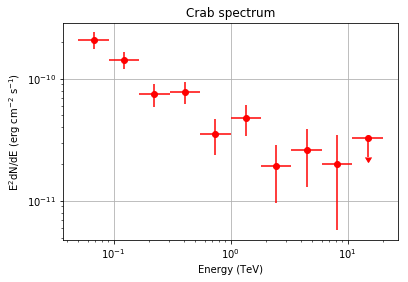

In [13]:
plot_spectrum(spectrum, "")